In [20]:
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

import pandas as pd

import plotly.graph_objects as go
import numpy as np

In [21]:
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession 
from pyspark.conf import SparkConf
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import StringType, IntegerType, StructType, StructField

In [22]:
spark = SparkSession \
    .builder \
    .appName("regression") \
    .master("local[4]") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.network.timeout","3600")\
    .config("spark.executor.heartbeatInterval","3000s")\
    .getOrCreate()

# TREND ANALYSIS

In [23]:
df = spark.read.json('../data/cleaned_dataset')
df.show(3,truncate=False,vertical =True)


-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------
 acousticness          | 0.658                                                                                                                              
 age                   | 41.821917808219176                                                                                                                 
 avg_artist_followers  | 5403.5                                                                                                                             
 avg_artist_popularity | 40.0                                                                                                                               
 danceability          | 0.602                                                                                                                              
 duration_ms           | 156067                           

In [24]:

technical_columns = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',  'speechiness', 'tempo', 'time_signature', 'valence']

In [25]:
from pyspark.sql.window import Window

df = df.withColumn('year',2021 - df.age.cast(IntegerType()))

windowSpec = Window.partitionBy("year") 
df = df.withColumn("popularity_norma",sum(col("popularity_track")).over(windowSpec))
df.select('year','popularity_norma').show()



+----+----------------+
|year|popularity_norma|
+----+----------------+
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
+----+----------------+
only showing top 20 rows



In [26]:
from functools import reduce

In [27]:


dfn = reduce(
    lambda memo_df, col_name: memo_df.withColumn(col_name+'_n', (col(col_name)*col('popularity_track')/col('popularity_norma'))  ),technical_columns,df)

dfn

DataFrame[acousticness: double, age: double, avg_artist_followers: double, avg_artist_popularity: double, danceability: double, duration_ms: bigint, energy: double, genres: array<string>, id_track: string, instrumentalness: double, key: bigint, liveness: double, loudness: double, mode: bigint, popularity_track: bigint, release_date: string, speechiness: double, sum_artist_followers: bigint, sum_artist_popularity: bigint, tempo: double, time_signature: bigint, valence: double, year: int, popularity_norma: bigint, acousticness_n: double, danceability_n: double, duration_ms_n: double, energy_n: double, instrumentalness_n: double, key_n: double, liveness_n: double, loudness_n: double, mode_n: double, speechiness_n: double, tempo_n: double, time_signature_n: double, valence_n: double]

In [28]:
dfn.show(3,vertical = True)

-RECORD 0-------------------------------------
 acousticness          | 0.568                
 age                   | 62.824657534246576   
 avg_artist_followers  | 208410.0             
 avg_artist_popularity | 57.0                 
 danceability          | 0.608                
 duration_ms           | 164067               
 energy                | 0.561                
 genres                | [adult standards,... 
 id_track              | 07BBsPSNZPEu21LDs... 
 instrumentalness      | 2.01E-5              
 key                   | 0                    
 liveness              | 0.0934               
 loudness              | -10.313              
 mode                  | 1                    
 popularity_track      | 11                   
 release_date          | 1959-01-05           
 speechiness           | 0.032                
 sum_artist_followers  | 208410               
 sum_artist_popularity | 57                   
 tempo                 | 112.796              
 time_signatu

In [29]:
for column in technical_columns:
    for aggr in ['min','max','avg']:
        s = "F."+aggr+"('"+column+"').alias('"+aggr+"_"+column+"'),\\"
        print(s,end='\n')
    print("F.sum('"+column+"_n').alias('wavg_"+column+"'),\\")
    

F.min('acousticness').alias('min_acousticness'),\
F.max('acousticness').alias('max_acousticness'),\
F.avg('acousticness').alias('avg_acousticness'),\
F.sum('acousticness_n').alias('wavg_acousticness'),\
F.min('danceability').alias('min_danceability'),\
F.max('danceability').alias('max_danceability'),\
F.avg('danceability').alias('avg_danceability'),\
F.sum('danceability_n').alias('wavg_danceability'),\
F.min('duration_ms').alias('min_duration_ms'),\
F.max('duration_ms').alias('max_duration_ms'),\
F.avg('duration_ms').alias('avg_duration_ms'),\
F.sum('duration_ms_n').alias('wavg_duration_ms'),\
F.min('energy').alias('min_energy'),\
F.max('energy').alias('max_energy'),\
F.avg('energy').alias('avg_energy'),\
F.sum('energy_n').alias('wavg_energy'),\
F.min('instrumentalness').alias('min_instrumentalness'),\
F.max('instrumentalness').alias('max_instrumentalness'),\
F.avg('instrumentalness').alias('avg_instrumentalness'),\
F.sum('instrumentalness_n').alias('wavg_instrumentalness'),\
F.min('ke

In [30]:
import pyspark.sql.functions as F

In [31]:

dfg = dfn.groupBy('year')\
    .agg(F.min('acousticness').alias('min_acousticness'),\
        F.max('acousticness').alias('max_acousticness'),\
        F.avg('acousticness').alias('avg_acousticness'),\
        F.sum('acousticness_n').alias('wavg_acousticness'),\
        F.min('danceability').alias('min_danceability'),\
        F.max('danceability').alias('max_danceability'),\
        F.avg('danceability').alias('avg_danceability'),\
        F.sum('danceability_n').alias('wavg_danceability'),\
        F.min('duration_ms').alias('min_duration_ms'),\
        F.max('duration_ms').alias('max_duration_ms'),\
        F.avg('duration_ms').alias('avg_duration_ms'),\
        F.sum('duration_ms_n').alias('wavg_duration_ms'),\
        F.min('energy').alias('min_energy'),\
        F.max('energy').alias('max_energy'),\
        F.avg('energy').alias('avg_energy'),\
        F.sum('energy_n').alias('wavg_energy'),\
        F.min('instrumentalness').alias('min_instrumentalness'),\
        F.max('instrumentalness').alias('max_instrumentalness'),\
        F.avg('instrumentalness').alias('avg_instrumentalness'),\
        F.sum('instrumentalness_n').alias('wavg_instrumentalness'),\
        F.min('key').alias('min_key'),\
        F.max('key').alias('max_key'),\
        F.avg('key').alias('avg_key'),\
        F.sum('key_n').alias('wavg_key'),\
        F.min('liveness').alias('min_liveness'),\
        F.max('liveness').alias('max_liveness'),\
        F.avg('liveness').alias('avg_liveness'),\
        F.sum('liveness_n').alias('wavg_liveness'),\
        F.min('loudness').alias('min_loudness'),\
        F.max('loudness').alias('max_loudness'),\
        F.avg('loudness').alias('avg_loudness'),\
        F.sum('loudness_n').alias('wavg_loudness'),\
        F.min('mode').alias('min_mode'),\
        F.max('mode').alias('max_mode'),\
        F.avg('mode').alias('avg_mode'),\
        F.sum('mode_n').alias('wavg_mode'),\
        F.min('speechiness').alias('min_speechiness'),\
        F.max('speechiness').alias('max_speechiness'),\
        F.avg('speechiness').alias('avg_speechiness'),\
        F.sum('speechiness_n').alias('wavg_speechiness'),\
        F.min('tempo').alias('min_tempo'),\
        F.max('tempo').alias('max_tempo'),\
        F.avg('tempo').alias('avg_tempo'),\
        F.sum('tempo_n').alias('wavg_tempo'),\
        F.min('time_signature').alias('min_time_signature'),\
        F.max('time_signature').alias('max_time_signature'),\
        F.avg('time_signature').alias('avg_time_signature'),\
        F.sum('time_signature_n').alias('wavg_time_signature'),\
        F.min('valence').alias('min_valence'),\
        F.max('valence').alias('max_valence'),\
        F.avg('valence').alias('avg_valence'),\
        F.sum('valence_n').alias('wavg_valence') )

In [32]:
dfg.printSchema()

root
 |-- year: integer (nullable = true)
 |-- min_acousticness: double (nullable = true)
 |-- max_acousticness: double (nullable = true)
 |-- avg_acousticness: double (nullable = true)
 |-- wavg_acousticness: double (nullable = true)
 |-- min_danceability: double (nullable = true)
 |-- max_danceability: double (nullable = true)
 |-- avg_danceability: double (nullable = true)
 |-- wavg_danceability: double (nullable = true)
 |-- min_duration_ms: long (nullable = true)
 |-- max_duration_ms: long (nullable = true)
 |-- avg_duration_ms: double (nullable = true)
 |-- wavg_duration_ms: double (nullable = true)
 |-- min_energy: double (nullable = true)
 |-- max_energy: double (nullable = true)
 |-- avg_energy: double (nullable = true)
 |-- wavg_energy: double (nullable = true)
 |-- min_instrumentalness: double (nullable = true)
 |-- max_instrumentalness: double (nullable = true)
 |-- avg_instrumentalness: double (nullable = true)
 |-- wavg_instrumentalness: double (nullable = true)
 |-- min_

In [85]:
dfg.count()

101

In [33]:
dfp = dfg.toPandas()

In [34]:
dfp.to_csv('../data/timeseries.csv')

### Design Trends

In [35]:

technical_columns = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',  'speechiness', 'tempo', 'time_signature', 'valence']

In [36]:
dfp = pd.read_csv('../data/timeseries.csv',index_col=0)
dfp

,year,min_acousticness,max_acousticness,avg_acousticness,wavg_acousticness,min_danceability,max_danceability,avg_danceability,wavg_danceability,min_duration_ms,...,avg_tempo,wavg_tempo,min_time_signature,max_time_signature,avg_time_signature,wavg_time_signature,min_valence,max_valence,avg_valence,wavg_valence
0,1959,0.000463,0.996,0.797920,0.781117,0.0000,0.952,0.484321,0.492480,30040,...,111.872823,112.341744,0,5,3.780429,3.791023,0.0000,0.989,0.508534,0.505048
1,1990,0.000001,0.996,0.396070,0.374543,0.0000,0.985,0.557751,0.557459,30467,...,119.539611,119.557828,0,5,3.883712,3.891658,0.0000,0.990,0.571420,0.566846
2,1975,0.000005,0.996,0.497883,0.466204,0.0641,0.947,0.519428,0.520134,31280,...,117.324881,117.781037,1,5,3.848027,3.862974,0.0000,0.994,0.571237,0.568436
3,1977,0.000002,0.996,0.481638,0.435098,0.0000,0.955,0.534042,0.536507,30107,...,118.901668,119.799414,0,5,3.841072,3.857665,0.0000,1.000,0.572814,0.571493
4,1924,0.000847,0.996,0.833162,0.971090,0.0000,0.869,0.628769,0.628067,97493,...,113.414818,105.523046,0,5,3.650972,3.956186,0.0000,0.977,0.610186,0.638443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1929,0.121000,0.996,0.954023,0.886166,0.0912,0.937,0.605083,0.601927,62212,...,118.917433,114.230870,1,5,3.862038,3.966321,0.0338,0.973,0.648447,0.638408
97,1928,0.000131,0.996,0.940836,0.950886,0.0650,0.901,0.541183,0.540457,34133,...,109.107917,114.833777,1,5,3.816401,3.807901,0.0324,0.976,0.522406,0.484554
98,1933,0.004040,0.996,0.830922,0.918262,0.0623,0.920,0.591387,0.620005,57980,...,112.571244,111.709462,1,5,3.783472,3.913198,0.0340,0.979,0.599417,0.598855
99,2021,0.000001,0.996,0.270236,0.277338,0.0000,0.987,0.662397,0.678670,23493,...,121.818194,122.464807,0,5,3.944104,3.953721,0.0000,0.986,0.500156,0.510634


In [37]:
dfp = dfp[dfp.year>1971]
dfp.set_index('year',inplace = True,drop=True)
dfp.sort_index(inplace=True)


C:\Users\carlo\anaconda3\envs\pyspark_env\lib\site-packages\pandas\core\frame.py:6402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key,


In [38]:
dfp

,min_acousticness,max_acousticness,avg_acousticness,wavg_acousticness,min_danceability,max_danceability,avg_danceability,wavg_danceability,min_duration_ms,max_duration_ms,...,avg_tempo,wavg_tempo,min_time_signature,max_time_signature,avg_time_signature,wavg_time_signature,min_valence,max_valence,avg_valence,wavg_valence
year,,,,,,,,,,,,,,,,,,,,,
1972,0.000007,0.996,0.546940,0.510003,0.0000,0.921,0.513294,0.518027,31453,4142067,...,116.609066,117.566475,0,5,3.832303,3.851738,0.00000,0.988,0.577270,0.579952
1973,0.000004,0.996,0.514682,0.475376,0.0000,0.942,0.518486,0.518216,14708,2052573,...,116.818559,117.818373,0,5,3.850962,3.867799,0.00000,0.989,0.574577,0.571809
1974,0.000003,0.996,0.522935,0.491428,0.0000,0.946,0.517479,0.517561,30067,3153173,...,117.329357,118.097608,0,5,3.848920,3.865882,0.00000,0.992,0.580689,0.584793
1975,0.000005,0.996,0.497883,0.466204,0.0641,0.947,0.519428,0.520134,31280,3091707,...,117.324881,117.781037,1,5,3.848027,3.862974,0.00000,0.994,0.571237,0.568436
1976,0.000004,0.995,0.488774,0.445149,0.0717,0.944,0.523765,0.525523,30667,3377907,...,117.723843,118.173898,0,5,3.864226,3.882220,0.02420,0.994,0.582466,0.579731
1977,0.000002,0.996,0.481638,0.435098,0.0000,0.955,0.534042,0.536507,30107,1750875,...,118.901668,119.799414,0,5,3.841072,3.857665,0.00000,1.000,0.572814,0.571493
1978,0.000000,0.996,0.447950,0.400609,0.0000,0.956,0.532305,0.538369,31265,3441840,...,118.763320,119.388872,0,5,3.867481,3.882232,0.00000,1.000,0.592228,0.596055
1979,0.000000,0.996,0.438439,0.400940,0.0000,0.947,0.564431,0.575700,30400,5621218,...,118.003438,118.017765,0,5,3.853822,3.860698,0.00000,0.997,0.610295,0.615718
1980,0.000007,0.996,0.431627,0.403211,0.0000,0.961,0.559924,0.570133,30120,2796951,...,118.994062,118.784987,0,5,3.832373,3.828379,0.00000,0.991,0.595041,0.594361


In [39]:
len(technical_columns)

13

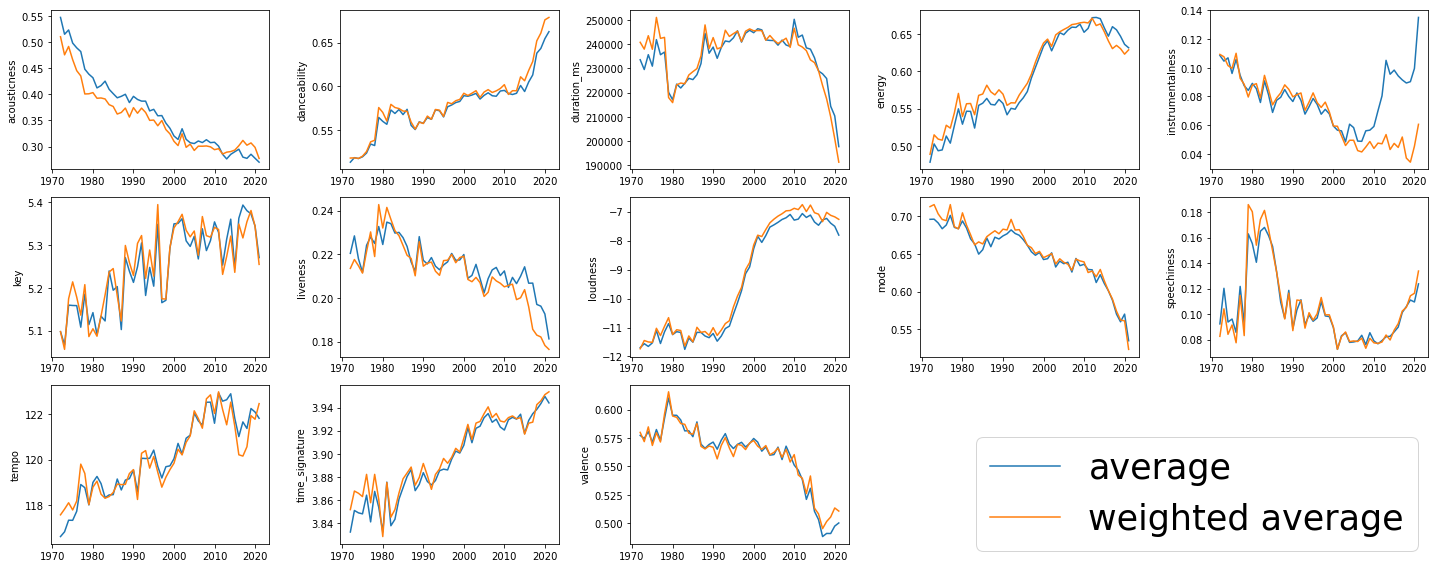

In [58]:
fig, axs = plt.subplots(3,5, figsize=(20, 8))
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for i,col in enumerate(technical_columns):
  #  col = technical_columns[0]
#plt.fill_between(dfp['min_'+col],dfp['max_'+col])
    axs[i].plot(dfp['avg_'+col],label='average')
    axs[i].plot(dfp['wavg_'+col],label='weighted average')
    axs[i].set_ylabel(col)
    #axs[i].legend()
  
while i +1 < 15 : 
  fig.delaxes(axs[i+1])
  i+=1


fig.legend( ['average','weighted average'], loc='lower right', fontsize=35)
    
plt.tight_layout()
plt.show()